In [1]:
import gym
import popgym
import numpy as np
from popgym.envs.stateless_cartpole import StatelessCartPole
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
from tqdm import trange
import tensorflow as tf
import numpy as np
import tqdm

c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:29: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from tensorflow.python.lib.core import _pywrap_bfloat16
c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:511: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:563: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 100

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.9

In [4]:
state_space=4
obs_space=2
action_space=2
intermediate_dim=16

In [5]:
env=StatelessCartPole()


In [6]:
print(env.action_space)
print(env.observation_space.shape[0])

Discrete(2)
2


In [7]:
class DQNSolver:

    def __init__(self, state_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(8, input_shape=(
            state_space,), activation="relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dense(4, activation="relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

        self.target_model = Sequential()
        self.target_model.add(Dense(8, input_shape=(
            state_space,), activation="relu"))
        self.target_model.add(BatchNormalization())
        self.target_model.add(Dense(4, activation="relu"))
        self.target_model.add(BatchNormalization())
        self.target_model.add(Dense(self.action_space, activation="linear"))
        self.target_model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        # if (len(self.memory) > 0):
        #     self.memory.pop()
        self.memory.append((state, action, reward, next_state, done))
    
    def forget(self):
        self.memory.clear()

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.target_model.set_weights(self.model.get_weights())


    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA *
                            np.amax(self.target_model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][int(action)] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [8]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(7,))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [9]:
dqn_solver=DQNSolver(state_space, action_space)


c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, input_features,var):
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      temp=[]
      for i in range(len(input_features)):
          temp.append(tf.concat((input_features[i],var[i]),axis=1))
      temp=tf.convert_to_tensor(temp)
      activation1 = self.hidden_layer1(temp)
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [11]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim,state_space=state_space)
    
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      obs_space=obs_space
    )
    
  
  def call(self, input_features,var):
    code = self.encoder(input_features)
    #self.var=tf.Variable(var,trainable=False)
    reconstructed = self.decoder(code,var)
    return reconstructed


opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [12]:

def loss(model,input_features, obs,var):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(input_features,var), obs)))
  return reconstruction_error
  
def train(loss, model, opt,input_features,obs,var):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model,input_features, obs,var), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

In [13]:
obs=env.reset()
obs

array([-0.02992456, -0.04916365, -0.00010376,  0.03876001], dtype=float32)

In [14]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)


In [15]:
def data_collection(total_episodes,dqn_solver,autoencoder):

    S_series=[]
    S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0]]))
    encoder=autoencoder.encoder
    decoder=autoencoder.decoder

    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        #s0=np.reshape(s0,[1,state_space])
        
        step=0
        done=False
        while not done:
            if(step==0):
                s=s0
                S_actual_series.append(s)
            else:
                s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,[1,state_space])
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,[1,state_space])
            S_series.append(s)
            action=dqn_solver.act(s)

            actual_state,obs, reward, done, info = env.step(int(action))
            reward=reward*200
            Done_series.append(done)
            actual_state=np.reshape(actual_state,[1,state_space])
            S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            reward = reward if not done else -reward
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred=decoder(s,action)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
        ep_no+=1
    return S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series


In [16]:
def dqn_training(dqn_solver,epochs,S_series,U_series,R_series,Done_series):
    dqn_solver.forget()
    for i in range(len(S_series)-1):
        dqn_solver.remember(S_series[i],U_series[i][0][0],R_series[i],S_series[i+1],Done_series[i])
    for j in trange(epochs):
        dqn_solver.experience_replay()
        if(j%2==0):
            dqn_solver.update_target_model()

In [17]:
def autoencoder_training(epochs,autoencoder,S_series,O_series,U_series):
    temp1=[]
    temp2=[]
    temp3=[]
    for i in range(2,len(S_series)-1):
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(10)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(10)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(10)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))
    
    for epoch in trange(epochs):
        for x in final_dataset:
            train(loss,autoencoder,opt,x[0],x[1],x[2])

In [18]:
rewards_storage=[]

In [19]:

def complete_loop(autoencoder,dqn_solver,epochs,EXPLORATION_MAX):
    for epoch in range(epochs):
        S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series=data_collection(100,dqn_solver,autoencoder)
        print("epoch: {}, total reward: {}".format(epoch, sum(R_series)))
        rewards_storage.append(sum(R_series))
        if(epoch%2==0):
            dqn_training(dqn_solver,10,S_series,U_series,R_series,Done_series)#50,500
            dqn_solver.exploration_rate=EXPLORATION_MAX
            EXPLORATION_MAX*=0.95
        else:
            autoencoder_training(10,autoencoder,S_series,O_series,U_series)

        
        

        


In [20]:
complete_loop(autoencoder,dqn_solver,3000,EXPLORATION_MAX=1.0)

epoch: 0, total reward: 2168.0


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


epoch: 1, total reward: 2061.0


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


epoch: 2, total reward: 1893.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 3, total reward: 1970.0


100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


epoch: 4, total reward: 1914.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 5, total reward: 2160.0


100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


epoch: 6, total reward: 1993.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 7, total reward: 2005.0


100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


epoch: 8, total reward: 1914.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 9, total reward: 1835.0


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


epoch: 10, total reward: 1753.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 11, total reward: 1705.0


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


epoch: 12, total reward: 1500.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 13, total reward: 1866.0


100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


epoch: 14, total reward: 1820.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 15, total reward: 1600.0


100%|██████████| 10/10 [00:38<00:00,  3.80s/it]


epoch: 16, total reward: 1580.0


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


epoch: 17, total reward: 1538.0


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


epoch: 18, total reward: 1454.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 19, total reward: 1396.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 20, total reward: 1360.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 21, total reward: 1225.0


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


epoch: 22, total reward: 1307.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 23, total reward: 1226.0


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


epoch: 24, total reward: 1338.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 25, total reward: 1262.0


100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


epoch: 26, total reward: 1249.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 27, total reward: 1127.0


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


epoch: 28, total reward: 1162.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 29, total reward: 1196.0


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


epoch: 30, total reward: 1143.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 31, total reward: 1100.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 32, total reward: 1071.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 33, total reward: 1115.0


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


epoch: 34, total reward: 1006.0


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


epoch: 35, total reward: 1056.0


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


epoch: 36, total reward: 1065.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 37, total reward: 1021.0


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


epoch: 38, total reward: 1026.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 39, total reward: 982.0


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


epoch: 40, total reward: 1039.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 41, total reward: 943.0


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


epoch: 42, total reward: 982.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 43, total reward: 971.0


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


epoch: 44, total reward: 958.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 45, total reward: 948.0


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


epoch: 46, total reward: 961.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 47, total reward: 943.0


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


epoch: 48, total reward: 952.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 49, total reward: 932.0


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


epoch: 50, total reward: 947.0


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


epoch: 51, total reward: 934.0


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


epoch: 52, total reward: 909.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 53, total reward: 941.0


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


epoch: 54, total reward: 920.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 55, total reward: 902.0


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


epoch: 56, total reward: 914.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 57, total reward: 877.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 58, total reward: 926.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 59, total reward: 847.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 60, total reward: 883.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 61, total reward: 849.0


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


epoch: 62, total reward: 854.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 63, total reward: 869.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 64, total reward: 848.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 65, total reward: 838.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 66, total reward: 863.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 67, total reward: 862.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 68, total reward: 838.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 69, total reward: 847.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 70, total reward: 862.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 71, total reward: 803.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 72, total reward: 835.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 73, total reward: 819.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 74, total reward: 847.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 75, total reward: 846.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 76, total reward: 805.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 77, total reward: 846.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 78, total reward: 823.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 79, total reward: 828.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 80, total reward: 808.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 81, total reward: 787.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 82, total reward: 831.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 83, total reward: 805.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 84, total reward: 790.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 85, total reward: 822.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 86, total reward: 805.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 87, total reward: 821.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 88, total reward: 798.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 89, total reward: 783.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 90, total reward: 807.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 91, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 92, total reward: 798.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 93, total reward: 800.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 94, total reward: 819.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 95, total reward: 813.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 96, total reward: 788.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 97, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 98, total reward: 801.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 99, total reward: 776.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 100, total reward: 795.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 101, total reward: 789.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 102, total reward: 841.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 103, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 104, total reward: 824.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 105, total reward: 841.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 106, total reward: 1470.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 107, total reward: 1247.0


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


epoch: 108, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 109, total reward: 767.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 110, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 111, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 112, total reward: 884.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 113, total reward: 840.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 114, total reward: 795.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 115, total reward: 820.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 116, total reward: 826.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 117, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 118, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 119, total reward: 1067.0


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


epoch: 120, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 121, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 122, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 123, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 124, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 125, total reward: 803.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 126, total reward: 785.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 127, total reward: 784.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 128, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 129, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 130, total reward: 797.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 131, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 132, total reward: 878.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 133, total reward: 841.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 134, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 135, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 136, total reward: 870.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 137, total reward: 807.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 138, total reward: 1267.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 139, total reward: 1095.0


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


epoch: 140, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 141, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 142, total reward: 795.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 143, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 144, total reward: 799.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 145, total reward: 822.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 146, total reward: 827.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 147, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 148, total reward: 774.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 149, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 150, total reward: 880.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 151, total reward: 1034.0


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


epoch: 152, total reward: 795.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 153, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 154, total reward: 981.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 155, total reward: 846.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 156, total reward: 749.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 157, total reward: 822.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 158, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 159, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 160, total reward: 795.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 161, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 162, total reward: 745.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 163, total reward: 775.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 164, total reward: 759.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 165, total reward: 780.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 166, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 167, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 168, total reward: 810.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 169, total reward: 848.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 170, total reward: 764.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 171, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 172, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 173, total reward: 784.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 174, total reward: 868.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 175, total reward: 882.0


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


epoch: 176, total reward: 795.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 177, total reward: 808.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 178, total reward: 788.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 179, total reward: 779.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 180, total reward: 842.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 181, total reward: 810.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 182, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 183, total reward: 784.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 184, total reward: 834.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 185, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 186, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 187, total reward: 861.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 188, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 189, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 190, total reward: 822.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 191, total reward: 813.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 192, total reward: 777.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 193, total reward: 825.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 194, total reward: 851.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 195, total reward: 783.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 196, total reward: 827.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 197, total reward: 755.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 198, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 199, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 200, total reward: 793.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 201, total reward: 823.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 202, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 203, total reward: 822.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 204, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 205, total reward: 826.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 206, total reward: 827.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 207, total reward: 793.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 208, total reward: 807.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 209, total reward: 974.0


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


epoch: 210, total reward: 779.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 211, total reward: 780.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 212, total reward: 824.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 213, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 214, total reward: 812.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 215, total reward: 792.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 216, total reward: 842.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 217, total reward: 826.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 218, total reward: 861.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 219, total reward: 874.0


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


epoch: 220, total reward: 783.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 221, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 222, total reward: 931.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 223, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 224, total reward: 783.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 225, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 226, total reward: 763.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 227, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 228, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 229, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 230, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 231, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 232, total reward: 740.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 233, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 234, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 235, total reward: 800.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 236, total reward: 805.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 237, total reward: 837.0


100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


epoch: 238, total reward: 816.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 239, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 240, total reward: 773.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 241, total reward: 777.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 242, total reward: 813.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 243, total reward: 798.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 244, total reward: 783.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 245, total reward: 788.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 246, total reward: 799.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 247, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 248, total reward: 847.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 249, total reward: 802.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 250, total reward: 738.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 251, total reward: 751.0


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


epoch: 252, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 253, total reward: 782.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 254, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 255, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 256, total reward: 746.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 257, total reward: 774.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 258, total reward: 780.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 259, total reward: 768.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 260, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 261, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch: 262, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 263, total reward: 811.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 264, total reward: 790.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 265, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


epoch: 266, total reward: 793.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 267, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 268, total reward: 750.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 269, total reward: 771.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 270, total reward: 811.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 271, total reward: 780.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 272, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 273, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


epoch: 274, total reward: 799.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 275, total reward: 825.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 276, total reward: 780.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 277, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 278, total reward: 797.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 279, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 280, total reward: 824.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 281, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 282, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 283, total reward: 789.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 284, total reward: 799.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 285, total reward: 790.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 286, total reward: 797.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 287, total reward: 860.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 288, total reward: 810.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 289, total reward: 779.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 290, total reward: 794.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 291, total reward: 809.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 292, total reward: 809.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 293, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 294, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 295, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 296, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 297, total reward: 806.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 298, total reward: 954.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 299, total reward: 856.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 300, total reward: 802.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 301, total reward: 922.0


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


epoch: 302, total reward: 919.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 303, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 304, total reward: 785.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 305, total reward: 815.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 306, total reward: 756.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 307, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 308, total reward: 800.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 309, total reward: 937.0


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


epoch: 310, total reward: 848.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 311, total reward: 1041.0


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


epoch: 312, total reward: 817.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 313, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 314, total reward: 785.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 315, total reward: 783.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 316, total reward: 817.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 317, total reward: 854.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 318, total reward: 761.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 319, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 320, total reward: 747.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 321, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 322, total reward: 746.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 323, total reward: 775.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 324, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 325, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 326, total reward: 814.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 327, total reward: 936.0


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


epoch: 328, total reward: 749.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 329, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 330, total reward: 748.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 331, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


epoch: 332, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 333, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch: 334, total reward: 771.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 335, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch: 336, total reward: 772.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 337, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 338, total reward: 775.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 339, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 340, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 341, total reward: 774.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 342, total reward: 789.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 343, total reward: 780.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 344, total reward: 774.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 345, total reward: 789.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 346, total reward: 799.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 347, total reward: 1122.0


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


epoch: 348, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 349, total reward: 756.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 350, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 351, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 352, total reward: 837.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 353, total reward: 1175.0


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


epoch: 354, total reward: 779.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 355, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 356, total reward: 1785.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 357, total reward: 1021.0


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


epoch: 358, total reward: 918.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 359, total reward: 1211.0


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


epoch: 360, total reward: 1767.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 361, total reward: 1272.0


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 362, total reward: 738.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 363, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 364, total reward: 791.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 365, total reward: 746.0


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch: 366, total reward: 765.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 367, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 368, total reward: 782.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 369, total reward: 791.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 370, total reward: 835.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 371, total reward: 816.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 372, total reward: 895.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 373, total reward: 1148.0


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


epoch: 374, total reward: 744.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 375, total reward: 778.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 376, total reward: 827.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 377, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 378, total reward: 741.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 379, total reward: 787.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 380, total reward: 815.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 381, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 382, total reward: 773.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 383, total reward: 805.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 384, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 385, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 386, total reward: 818.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 387, total reward: 968.0


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


epoch: 388, total reward: 1361.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 389, total reward: 876.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 390, total reward: 792.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 391, total reward: 801.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 392, total reward: 1102.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 393, total reward: 769.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 394, total reward: 800.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 395, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 396, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 397, total reward: 784.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 398, total reward: 798.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 399, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 400, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 401, total reward: 808.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 402, total reward: 849.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 403, total reward: 1221.0


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


epoch: 404, total reward: 763.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 405, total reward: 807.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 406, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 407, total reward: 793.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 408, total reward: 775.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 409, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 410, total reward: 813.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 411, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 412, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 413, total reward: 797.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 414, total reward: 884.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 415, total reward: 812.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 416, total reward: 829.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 417, total reward: 801.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 418, total reward: 1031.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 419, total reward: 924.0


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


epoch: 420, total reward: 867.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 421, total reward: 1287.0


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


epoch: 422, total reward: 1831.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 423, total reward: 1084.0


100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


epoch: 424, total reward: 785.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 425, total reward: 1614.0


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


epoch: 426, total reward: 798.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 427, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 428, total reward: 779.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 429, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 430, total reward: 828.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 431, total reward: 778.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 432, total reward: 807.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 433, total reward: 788.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 434, total reward: 817.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 435, total reward: 858.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 436, total reward: 854.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 437, total reward: 846.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 438, total reward: 746.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 439, total reward: 795.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 440, total reward: 830.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 441, total reward: 908.0


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


epoch: 442, total reward: 804.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 443, total reward: 829.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 444, total reward: 808.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 445, total reward: 837.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 446, total reward: 887.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 447, total reward: 1019.0


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


epoch: 448, total reward: 844.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 449, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 450, total reward: 902.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 451, total reward: 897.0


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


epoch: 452, total reward: 799.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 453, total reward: 805.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 454, total reward: 813.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 455, total reward: 872.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 456, total reward: 835.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 457, total reward: 844.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 458, total reward: 945.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 459, total reward: 946.0


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


epoch: 460, total reward: 896.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 461, total reward: 839.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 462, total reward: 955.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 463, total reward: 898.0


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


epoch: 464, total reward: 852.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 465, total reward: 838.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 466, total reward: 1001.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 467, total reward: 808.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 468, total reward: 928.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 469, total reward: 972.0


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


epoch: 470, total reward: 892.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 471, total reward: 904.0


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


epoch: 472, total reward: 834.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 473, total reward: 886.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 474, total reward: 884.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 475, total reward: 847.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 476, total reward: 901.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 477, total reward: 836.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 478, total reward: 924.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 479, total reward: 907.0


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


epoch: 480, total reward: 1118.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 481, total reward: 987.0


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


epoch: 482, total reward: 975.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 483, total reward: 1017.0


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


epoch: 484, total reward: 819.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 485, total reward: 808.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 486, total reward: 983.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 487, total reward: 920.0


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


epoch: 488, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 489, total reward: 938.0


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


epoch: 490, total reward: 944.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 491, total reward: 888.0


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


epoch: 492, total reward: 907.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 493, total reward: 986.0


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


epoch: 494, total reward: 1072.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 495, total reward: 927.0


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


epoch: 496, total reward: 814.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 497, total reward: 844.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 498, total reward: 856.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 499, total reward: 851.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 500, total reward: 783.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 501, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 502, total reward: 778.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 503, total reward: 790.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 504, total reward: 776.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 505, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


epoch: 506, total reward: 777.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 507, total reward: 860.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 508, total reward: 855.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 509, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 510, total reward: 818.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 511, total reward: 744.0


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


epoch: 512, total reward: 1555.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 513, total reward: 1462.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 514, total reward: 1122.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 515, total reward: 953.0


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


epoch: 516, total reward: 1170.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 517, total reward: 1675.0


100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


epoch: 518, total reward: 804.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 519, total reward: 827.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 520, total reward: 900.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 521, total reward: 885.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 522, total reward: 770.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 523, total reward: 828.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 524, total reward: 913.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 525, total reward: 863.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 526, total reward: 995.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 527, total reward: 995.0


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


epoch: 528, total reward: 1059.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 529, total reward: 951.0


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


epoch: 530, total reward: 1179.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 531, total reward: 1018.0


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


epoch: 532, total reward: 928.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 533, total reward: 1302.0


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


epoch: 534, total reward: 739.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 535, total reward: 852.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 536, total reward: 894.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 537, total reward: 852.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 538, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 539, total reward: 792.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 540, total reward: 766.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 541, total reward: 775.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 542, total reward: 799.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 543, total reward: 797.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 544, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 545, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 546, total reward: 824.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 547, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 548, total reward: 823.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 549, total reward: 909.0


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


epoch: 550, total reward: 885.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 551, total reward: 837.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 552, total reward: 841.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 553, total reward: 955.0


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


epoch: 554, total reward: 801.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 555, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 556, total reward: 1006.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 557, total reward: 1045.0


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


epoch: 558, total reward: 855.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 559, total reward: 827.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 560, total reward: 761.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 561, total reward: 861.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 562, total reward: 858.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 563, total reward: 829.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 564, total reward: 814.0


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


epoch: 565, total reward: 868.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 566, total reward: 861.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 567, total reward: 891.0


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


epoch: 568, total reward: 761.0


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


epoch: 569, total reward: 773.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 570, total reward: 776.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 571, total reward: 774.0


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


epoch: 572, total reward: 740.0


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


epoch: 573, total reward: 783.0


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


epoch: 574, total reward: 752.0


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


epoch: 575, total reward: 767.0


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


epoch: 576, total reward: 812.0


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


epoch: 577, total reward: 782.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 578, total reward: 764.0


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


epoch: 579, total reward: 769.0


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


epoch: 580, total reward: 784.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 581, total reward: 779.0


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


epoch: 582, total reward: 931.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 583, total reward: 1119.0


100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


epoch: 584, total reward: 851.0


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


epoch: 585, total reward: 1256.0


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


epoch: 586, total reward: 1454.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 587, total reward: 1124.0


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


epoch: 588, total reward: 999.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 589, total reward: 1236.0


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


epoch: 590, total reward: 1249.0


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


epoch: 591, total reward: 1424.0


100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


epoch: 592, total reward: 1342.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 593, total reward: 1253.0


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


epoch: 594, total reward: 996.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 595, total reward: 1268.0


100%|██████████| 10/10 [00:41<00:00,  4.10s/it]


epoch: 596, total reward: 1394.0


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


epoch: 597, total reward: 1220.0


100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


epoch: 598, total reward: 832.0


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


epoch: 599, total reward: 825.0


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


epoch: 600, total reward: 871.0


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


epoch: 601, total reward: 878.0


100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


epoch: 602, total reward: 983.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 603, total reward: 1168.0


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


epoch: 604, total reward: 925.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 605, total reward: 820.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 606, total reward: 1159.0


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


epoch: 607, total reward: 1081.0


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


epoch: 608, total reward: 1008.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 609, total reward: 1104.0


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


epoch: 610, total reward: 818.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 611, total reward: 1275.0


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


epoch: 612, total reward: 1284.0


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


epoch: 613, total reward: 1096.0


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


epoch: 614, total reward: 1421.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 615, total reward: 806.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 616, total reward: 730.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 617, total reward: 1218.0


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


epoch: 618, total reward: 859.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 619, total reward: 1188.0


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


epoch: 620, total reward: 1272.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 621, total reward: 989.0


100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


epoch: 622, total reward: 1144.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 623, total reward: 1085.0


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


epoch: 624, total reward: 1152.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 625, total reward: 1182.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 626, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


epoch: 627, total reward: 802.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 628, total reward: 745.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 629, total reward: 795.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 630, total reward: 855.0


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


epoch: 631, total reward: 827.0


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


epoch: 632, total reward: 872.0


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


epoch: 633, total reward: 810.0


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


epoch: 634, total reward: 850.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 635, total reward: 783.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 636, total reward: 898.0


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


epoch: 637, total reward: 814.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 638, total reward: 772.0


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


epoch: 639, total reward: 931.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 640, total reward: 786.0


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


epoch: 641, total reward: 739.0


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


epoch: 642, total reward: 963.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 643, total reward: 889.0


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


epoch: 644, total reward: 727.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 645, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 646, total reward: 784.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 647, total reward: 806.0


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


epoch: 648, total reward: 808.0


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


epoch: 649, total reward: 771.0


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


epoch: 650, total reward: 773.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 651, total reward: 1325.0


100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


epoch: 652, total reward: 1325.0


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


epoch: 653, total reward: 1262.0


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


epoch: 654, total reward: 781.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 655, total reward: 1039.0


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


epoch: 656, total reward: 1371.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 657, total reward: 1638.0


100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


epoch: 658, total reward: 1805.0


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


epoch: 659, total reward: 781.0


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


epoch: 660, total reward: 900.0


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


epoch: 661, total reward: 925.0


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


epoch: 662, total reward: 891.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 663, total reward: 876.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 664, total reward: 1098.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 665, total reward: 1202.0


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


epoch: 666, total reward: 885.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 667, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 668, total reward: 829.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 669, total reward: 786.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 670, total reward: 841.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 671, total reward: 835.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 672, total reward: 870.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 673, total reward: 890.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 674, total reward: 901.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 675, total reward: 924.0


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


epoch: 676, total reward: 1052.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 677, total reward: 1010.0


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


epoch: 678, total reward: 825.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 679, total reward: 776.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 680, total reward: 761.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 681, total reward: 824.0


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


epoch: 682, total reward: 882.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 683, total reward: 824.0


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


epoch: 684, total reward: 771.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 685, total reward: 996.0


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


epoch: 686, total reward: 1076.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 687, total reward: 1129.0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


epoch: 688, total reward: 1012.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 689, total reward: 975.0


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


epoch: 690, total reward: 1075.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 691, total reward: 1024.0


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


epoch: 692, total reward: 1373.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 693, total reward: 1194.0


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


epoch: 694, total reward: 772.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 695, total reward: 1325.0


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


epoch: 696, total reward: 871.0


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


epoch: 697, total reward: 1011.0


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


epoch: 698, total reward: 786.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 699, total reward: 968.0


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


epoch: 700, total reward: 812.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 701, total reward: 795.0


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


epoch: 702, total reward: 792.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 703, total reward: 800.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 704, total reward: 948.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 705, total reward: 930.0


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


epoch: 706, total reward: 1013.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 707, total reward: 1082.0


100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


epoch: 708, total reward: 897.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 709, total reward: 922.0


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


epoch: 710, total reward: 843.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 711, total reward: 793.0


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


epoch: 712, total reward: 816.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 713, total reward: 820.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 714, total reward: 1004.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 715, total reward: 1123.0


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


epoch: 716, total reward: 1605.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 717, total reward: 981.0


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


epoch: 718, total reward: 858.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 719, total reward: 935.0


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


epoch: 720, total reward: 759.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 721, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 722, total reward: 918.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 723, total reward: 869.0


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


epoch: 724, total reward: 1205.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 725, total reward: 1081.0


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


epoch: 726, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 727, total reward: 857.0


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


epoch: 728, total reward: 1225.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 729, total reward: 965.0


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


epoch: 730, total reward: 1036.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 731, total reward: 859.0


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


epoch: 732, total reward: 803.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 733, total reward: 1088.0


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


epoch: 734, total reward: 1656.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 735, total reward: 1169.0


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


epoch: 736, total reward: 1380.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 737, total reward: 1166.0


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


epoch: 738, total reward: 1402.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 739, total reward: 1131.0


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


epoch: 740, total reward: 741.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 741, total reward: 3221.0


100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


epoch: 742, total reward: 765.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 743, total reward: 1584.0


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


epoch: 744, total reward: 2465.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 745, total reward: 1080.0


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


epoch: 746, total reward: 3825.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 747, total reward: 817.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 748, total reward: 1489.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 749, total reward: 1367.0


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


epoch: 750, total reward: 1323.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 751, total reward: 1678.0


100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


epoch: 752, total reward: 1361.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 753, total reward: 921.0


100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


epoch: 754, total reward: 784.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 755, total reward: 787.0


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


epoch: 756, total reward: 747.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 757, total reward: 786.0


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


epoch: 758, total reward: 1029.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 759, total reward: 979.0


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


epoch: 760, total reward: 826.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 761, total reward: 980.0


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


epoch: 762, total reward: 834.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 763, total reward: 948.0


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


epoch: 764, total reward: 962.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 765, total reward: 1000.0


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


epoch: 766, total reward: 998.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 767, total reward: 918.0


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


epoch: 768, total reward: 888.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 769, total reward: 1026.0


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


epoch: 770, total reward: 1082.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 771, total reward: 997.0


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


epoch: 772, total reward: 1215.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 773, total reward: 1111.0


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


epoch: 774, total reward: 942.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 775, total reward: 1183.0


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


epoch: 776, total reward: 819.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 777, total reward: 799.0


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


epoch: 778, total reward: 864.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 779, total reward: 1043.0


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


epoch: 780, total reward: 811.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 781, total reward: 816.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 782, total reward: 1009.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 783, total reward: 907.0


100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


epoch: 784, total reward: 762.0


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


epoch: 785, total reward: 1111.0


100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


epoch: 786, total reward: 906.0


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


epoch: 787, total reward: 941.0


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


epoch: 788, total reward: 883.0


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


epoch: 789, total reward: 884.0


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


epoch: 790, total reward: 976.0


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


epoch: 791, total reward: 917.0


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


epoch: 792, total reward: 949.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 793, total reward: 939.0


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


epoch: 794, total reward: 939.0


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


epoch: 795, total reward: 960.0


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 796, total reward: 956.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 797, total reward: 930.0


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


epoch: 798, total reward: 902.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 799, total reward: 922.0


100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


epoch: 800, total reward: 892.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 801, total reward: 792.0


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


epoch: 802, total reward: 979.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 803, total reward: 1012.0


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


epoch: 804, total reward: 966.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 805, total reward: 958.0


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


epoch: 806, total reward: 950.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 807, total reward: 945.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 808, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 809, total reward: 769.0


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


epoch: 810, total reward: 803.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 811, total reward: 1032.0


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


epoch: 812, total reward: 1020.0


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


epoch: 813, total reward: 953.0


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


epoch: 814, total reward: 1011.0


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


epoch: 815, total reward: 893.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 816, total reward: 792.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 817, total reward: 979.0


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


epoch: 818, total reward: 891.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 819, total reward: 1117.0


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


epoch: 820, total reward: 1082.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 821, total reward: 959.0


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


epoch: 822, total reward: 860.0


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


epoch: 823, total reward: 888.0


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


epoch: 824, total reward: 782.0


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


epoch: 825, total reward: 897.0


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


epoch: 826, total reward: 794.0


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


epoch: 827, total reward: 1050.0


100%|██████████| 10/10 [00:36<00:00,  3.70s/it]


epoch: 828, total reward: 1046.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 829, total reward: 868.0


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


epoch: 830, total reward: 940.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 831, total reward: 860.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 832, total reward: 805.0


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


epoch: 833, total reward: 829.0


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


epoch: 834, total reward: 1085.0


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


epoch: 835, total reward: 803.0


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


epoch: 836, total reward: 832.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 837, total reward: 860.0


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


epoch: 838, total reward: 860.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 839, total reward: 918.0


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


epoch: 840, total reward: 759.0


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


epoch: 841, total reward: 765.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 842, total reward: 821.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 843, total reward: 833.0


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


epoch: 844, total reward: 1046.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 845, total reward: 1005.0


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


epoch: 846, total reward: 837.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 847, total reward: 824.0


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


epoch: 848, total reward: 864.0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


epoch: 849, total reward: 1125.0


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


epoch: 850, total reward: 804.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 851, total reward: 769.0


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


epoch: 852, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 853, total reward: 786.0


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


epoch: 854, total reward: 803.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 855, total reward: 781.0


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


epoch: 856, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 857, total reward: 756.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 858, total reward: 754.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 859, total reward: 800.0


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


epoch: 860, total reward: 773.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 861, total reward: 796.0


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


epoch: 862, total reward: 982.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 863, total reward: 944.0


100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


epoch: 864, total reward: 822.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 865, total reward: 796.0


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


epoch: 866, total reward: 852.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 867, total reward: 808.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 868, total reward: 764.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 869, total reward: 764.0


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


epoch: 870, total reward: 743.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 871, total reward: 766.0


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


epoch: 872, total reward: 770.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 873, total reward: 771.0


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


epoch: 874, total reward: 783.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 875, total reward: 727.0


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


epoch: 876, total reward: 742.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 877, total reward: 799.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 878, total reward: 771.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 879, total reward: 759.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 880, total reward: 753.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 881, total reward: 759.0


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


epoch: 882, total reward: 748.0


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


epoch: 883, total reward: 778.0


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


epoch: 884, total reward: 818.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 885, total reward: 765.0


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


epoch: 886, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 887, total reward: 765.0


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]


epoch: 888, total reward: 773.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 889, total reward: 790.0


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


epoch: 890, total reward: 746.0


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


epoch: 891, total reward: 769.0


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


epoch: 892, total reward: 791.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 893, total reward: 768.0


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


epoch: 894, total reward: 847.0


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


epoch: 895, total reward: 743.0


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


epoch: 896, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 897, total reward: 772.0


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


epoch: 898, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 899, total reward: 777.0


100%|██████████| 10/10 [00:42<00:00,  4.24s/it]


epoch: 900, total reward: 748.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 901, total reward: 799.0


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


epoch: 902, total reward: 739.0


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


epoch: 903, total reward: 823.0


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


epoch: 904, total reward: 954.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 905, total reward: 1263.0


100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


epoch: 906, total reward: 913.0


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


epoch: 907, total reward: 808.0


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


epoch: 908, total reward: 867.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 909, total reward: 865.0


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


epoch: 910, total reward: 920.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 911, total reward: 945.0


100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


epoch: 912, total reward: 954.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 913, total reward: 902.0


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


epoch: 914, total reward: 917.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 915, total reward: 858.0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


epoch: 916, total reward: 1399.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 917, total reward: 1070.0


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


epoch: 918, total reward: 880.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 919, total reward: 977.0


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


epoch: 920, total reward: 987.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 921, total reward: 876.0


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


epoch: 922, total reward: 971.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 923, total reward: 949.0


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


epoch: 924, total reward: 841.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 925, total reward: 963.0


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


epoch: 926, total reward: 1023.0


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


epoch: 927, total reward: 1079.0


100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


epoch: 928, total reward: 1010.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 929, total reward: 994.0


100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


epoch: 930, total reward: 1032.0


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


epoch: 931, total reward: 971.0


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


epoch: 932, total reward: 917.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 933, total reward: 842.0


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]


epoch: 934, total reward: 927.0


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


epoch: 935, total reward: 1047.0


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


epoch: 936, total reward: 999.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 937, total reward: 939.0


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


epoch: 938, total reward: 896.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 939, total reward: 909.0


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


epoch: 940, total reward: 936.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 941, total reward: 962.0


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


epoch: 942, total reward: 944.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 943, total reward: 970.0


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


epoch: 944, total reward: 903.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 945, total reward: 977.0


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


epoch: 946, total reward: 1011.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 947, total reward: 1028.0


100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


epoch: 948, total reward: 905.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 949, total reward: 887.0


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


epoch: 950, total reward: 900.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 951, total reward: 917.0


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


epoch: 952, total reward: 860.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 953, total reward: 869.0


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


epoch: 954, total reward: 925.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 955, total reward: 889.0


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


epoch: 956, total reward: 931.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 957, total reward: 916.0


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


epoch: 958, total reward: 917.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 959, total reward: 908.0


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


epoch: 960, total reward: 906.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 961, total reward: 893.0


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


epoch: 962, total reward: 885.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 963, total reward: 943.0


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


epoch: 964, total reward: 959.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 965, total reward: 884.0


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


epoch: 966, total reward: 972.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 967, total reward: 988.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 968, total reward: 958.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 969, total reward: 997.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 970, total reward: 908.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 971, total reward: 909.0


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]


epoch: 972, total reward: 933.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 973, total reward: 1060.0


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


epoch: 974, total reward: 915.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 975, total reward: 895.0


100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


epoch: 976, total reward: 880.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 977, total reward: 875.0


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


epoch: 978, total reward: 927.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 979, total reward: 859.0


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


epoch: 980, total reward: 867.0


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


epoch: 981, total reward: 902.0


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


epoch: 982, total reward: 907.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 983, total reward: 1092.0


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


epoch: 984, total reward: 921.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 985, total reward: 1020.0


100%|██████████| 10/10 [00:36<00:00,  3.69s/it]


epoch: 986, total reward: 947.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 987, total reward: 896.0


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


epoch: 988, total reward: 882.0


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


epoch: 989, total reward: 916.0


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


epoch: 990, total reward: 1101.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 991, total reward: 1041.0


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


epoch: 992, total reward: 1123.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 993, total reward: 1072.0


100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


epoch: 994, total reward: 995.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 995, total reward: 947.0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


epoch: 996, total reward: 874.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 997, total reward: 952.0


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


epoch: 998, total reward: 886.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 999, total reward: 954.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 1000, total reward: 927.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1001, total reward: 921.0


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


epoch: 1002, total reward: 924.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1003, total reward: 988.0


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


epoch: 1004, total reward: 1090.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1005, total reward: 1077.0


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


epoch: 1006, total reward: 940.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1007, total reward: 912.0


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


epoch: 1008, total reward: 898.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1009, total reward: 971.0


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


epoch: 1010, total reward: 1044.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1011, total reward: 992.0


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


epoch: 1012, total reward: 1000.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1013, total reward: 1034.0


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


epoch: 1014, total reward: 995.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1015, total reward: 977.0


100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


epoch: 1016, total reward: 942.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1017, total reward: 915.0


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


epoch: 1018, total reward: 896.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1019, total reward: 901.0


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


epoch: 1020, total reward: 940.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1021, total reward: 912.0


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


epoch: 1022, total reward: 848.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1023, total reward: 888.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 1024, total reward: 911.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1025, total reward: 863.0


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


epoch: 1026, total reward: 871.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1027, total reward: 919.0


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


epoch: 1028, total reward: 1086.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1029, total reward: 1011.0


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


epoch: 1030, total reward: 975.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1031, total reward: 943.0


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


epoch: 1032, total reward: 1017.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1033, total reward: 925.0


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


epoch: 1034, total reward: 958.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1035, total reward: 1017.0


100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


epoch: 1036, total reward: 1037.0


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


epoch: 1037, total reward: 1183.0


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


epoch: 1038, total reward: 1248.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1039, total reward: 1086.0


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


epoch: 1040, total reward: 912.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1041, total reward: 1046.0


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


epoch: 1042, total reward: 1177.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1043, total reward: 891.0


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 1044, total reward: 925.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1045, total reward: 1093.0


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


epoch: 1046, total reward: 1174.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1047, total reward: 907.0


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


epoch: 1048, total reward: 1091.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1049, total reward: 889.0


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 1050, total reward: 1034.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1051, total reward: 937.0


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


epoch: 1052, total reward: 983.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1053, total reward: 980.0


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


epoch: 1054, total reward: 932.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1055, total reward: 1271.0


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


epoch: 1056, total reward: 1012.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1057, total reward: 956.0


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


epoch: 1058, total reward: 1053.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1059, total reward: 995.0


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


epoch: 1060, total reward: 978.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1061, total reward: 860.0


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


epoch: 1062, total reward: 776.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1063, total reward: 1064.0


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


epoch: 1064, total reward: 1172.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1065, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1066, total reward: 895.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1067, total reward: 881.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 1068, total reward: 887.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1069, total reward: 917.0


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 1070, total reward: 804.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1071, total reward: 960.0


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


epoch: 1072, total reward: 961.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1073, total reward: 892.0


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


epoch: 1074, total reward: 840.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1075, total reward: 851.0


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


epoch: 1076, total reward: 894.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1077, total reward: 903.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 1078, total reward: 920.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1079, total reward: 890.0


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


epoch: 1080, total reward: 987.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1081, total reward: 807.0


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


epoch: 1082, total reward: 893.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1083, total reward: 907.0


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


epoch: 1084, total reward: 913.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1085, total reward: 955.0


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


epoch: 1086, total reward: 850.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1087, total reward: 815.0


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


epoch: 1088, total reward: 895.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1089, total reward: 834.0


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


epoch: 1090, total reward: 842.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1091, total reward: 835.0


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


epoch: 1092, total reward: 859.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1093, total reward: 880.0


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


epoch: 1094, total reward: 891.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1095, total reward: 842.0


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


epoch: 1096, total reward: 900.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1097, total reward: 872.0


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


epoch: 1098, total reward: 903.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1099, total reward: 883.0


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


epoch: 1100, total reward: 974.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1101, total reward: 896.0


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


epoch: 1102, total reward: 839.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1103, total reward: 879.0


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


epoch: 1104, total reward: 1498.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1105, total reward: 1311.0


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


epoch: 1106, total reward: 1243.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1107, total reward: 1057.0


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


epoch: 1108, total reward: 1132.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1109, total reward: 1125.0


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


epoch: 1110, total reward: 897.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1111, total reward: 1232.0


100%|██████████| 10/10 [00:36<00:00,  3.60s/it]


epoch: 1112, total reward: 892.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1113, total reward: 850.0


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


epoch: 1114, total reward: 873.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1115, total reward: 821.0


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


epoch: 1116, total reward: 788.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1117, total reward: 807.0


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


epoch: 1118, total reward: 795.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1119, total reward: 785.0


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


epoch: 1120, total reward: 962.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1121, total reward: 839.0


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


epoch: 1122, total reward: 801.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1123, total reward: 816.0


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


epoch: 1124, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1125, total reward: 786.0


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


epoch: 1126, total reward: 764.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 1127, total reward: 779.0


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


epoch: 1128, total reward: 774.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1129, total reward: 800.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 1130, total reward: 791.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1131, total reward: 786.0


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


epoch: 1132, total reward: 798.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1133, total reward: 784.0


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


epoch: 1134, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1135, total reward: 811.0


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


epoch: 1136, total reward: 1022.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1137, total reward: 1213.0


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


epoch: 1138, total reward: 949.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1139, total reward: 903.0


100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


epoch: 1140, total reward: 868.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1141, total reward: 914.0


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


epoch: 1142, total reward: 832.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1143, total reward: 813.0


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


epoch: 1144, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1145, total reward: 800.0


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


epoch: 1146, total reward: 775.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1147, total reward: 772.0


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


epoch: 1148, total reward: 803.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1149, total reward: 837.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 1150, total reward: 884.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1151, total reward: 969.0


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


epoch: 1152, total reward: 854.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1153, total reward: 866.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 1154, total reward: 778.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1155, total reward: 769.0


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


epoch: 1156, total reward: 811.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1157, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1158, total reward: 756.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1159, total reward: 778.0


100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


epoch: 1160, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 1161, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1162, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1163, total reward: 776.0


100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


epoch: 1164, total reward: 849.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1165, total reward: 802.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1166, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 1167, total reward: 794.0


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


epoch: 1168, total reward: 831.0


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


epoch: 1169, total reward: 786.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1170, total reward: 769.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 1171, total reward: 894.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 1172, total reward: 842.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1173, total reward: 831.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1174, total reward: 820.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1175, total reward: 774.0


100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


epoch: 1176, total reward: 782.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1177, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1178, total reward: 780.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 1179, total reward: 859.0


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


epoch: 1180, total reward: 840.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1181, total reward: 784.0


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


epoch: 1182, total reward: 926.0


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


epoch: 1183, total reward: 873.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1184, total reward: 1162.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1185, total reward: 842.0


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


epoch: 1186, total reward: 983.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1187, total reward: 1286.0


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


epoch: 1188, total reward: 755.0


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


epoch: 1189, total reward: 873.0


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


epoch: 1190, total reward: 816.0


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


epoch: 1191, total reward: 814.0


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


epoch: 1192, total reward: 777.0


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


epoch: 1193, total reward: 872.0


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


epoch: 1194, total reward: 825.0


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


epoch: 1195, total reward: 818.0


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


epoch: 1196, total reward: 878.0


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


epoch: 1197, total reward: 897.0


100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


epoch: 1198, total reward: 742.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1199, total reward: 946.0


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


epoch: 1200, total reward: 849.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1201, total reward: 784.0


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


epoch: 1202, total reward: 791.0


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


epoch: 1203, total reward: 736.0


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


epoch: 1204, total reward: 843.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1205, total reward: 842.0


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


epoch: 1206, total reward: 759.0


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


epoch: 1207, total reward: 774.0


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


epoch: 1208, total reward: 752.0


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


epoch: 1209, total reward: 772.0


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


epoch: 1210, total reward: 761.0


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


epoch: 1211, total reward: 755.0


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


epoch: 1212, total reward: 810.0


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


epoch: 1213, total reward: 750.0


100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


epoch: 1214, total reward: 744.0


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


epoch: 1215, total reward: 776.0


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 1216, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


epoch: 1217, total reward: 756.0


100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


epoch: 1218, total reward: 731.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1219, total reward: 790.0


100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


epoch: 1220, total reward: 791.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1221, total reward: 741.0


100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


epoch: 1222, total reward: 743.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1223, total reward: 782.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1224, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1225, total reward: 746.0


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


epoch: 1226, total reward: 749.0


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


epoch: 1227, total reward: 763.0


100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


epoch: 1228, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 1229, total reward: 758.0


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


epoch: 1230, total reward: 773.0


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


epoch: 1231, total reward: 761.0


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


epoch: 1232, total reward: 784.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1233, total reward: 774.0


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


epoch: 1234, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1235, total reward: 763.0


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


epoch: 1236, total reward: 750.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1237, total reward: 751.0


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


epoch: 1238, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1239, total reward: 776.0


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 1240, total reward: 757.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 1241, total reward: 760.0


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


epoch: 1242, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1243, total reward: 754.0


100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


epoch: 1244, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 1245, total reward: 765.0


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


epoch: 1246, total reward: 760.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1247, total reward: 747.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1248, total reward: 805.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1249, total reward: 759.0


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


epoch: 1250, total reward: 817.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1251, total reward: 803.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1252, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1253, total reward: 762.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1254, total reward: 762.0


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


epoch: 1255, total reward: 772.0


100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


epoch: 1256, total reward: 766.0


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


epoch: 1257, total reward: 789.0


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


epoch: 1258, total reward: 819.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 1259, total reward: 798.0


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


epoch: 1260, total reward: 826.0


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


epoch: 1261, total reward: 779.0


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


epoch: 1262, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch: 1263, total reward: 761.0


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


epoch: 1264, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1265, total reward: 767.0


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


epoch: 1266, total reward: 755.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 1267, total reward: 797.0


100%|██████████| 10/10 [00:22<00:00,  2.30s/it]


epoch: 1268, total reward: 752.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1269, total reward: 784.0


100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


epoch: 1270, total reward: 783.0


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


epoch: 1271, total reward: 798.0


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


epoch: 1272, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1273, total reward: 766.0


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


epoch: 1274, total reward: 778.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1275, total reward: 766.0


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


epoch: 1276, total reward: 740.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1277, total reward: 778.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1278, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1279, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1280, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1281, total reward: 766.0


100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


epoch: 1282, total reward: 814.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1283, total reward: 773.0


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


epoch: 1284, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1285, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1286, total reward: 808.0


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


epoch: 1287, total reward: 736.0


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


epoch: 1288, total reward: 736.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1289, total reward: 780.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 1290, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1291, total reward: 766.0


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


epoch: 1292, total reward: 812.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1293, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1294, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1295, total reward: 793.0


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


epoch: 1296, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1297, total reward: 768.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1298, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1299, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1300, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1301, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1302, total reward: 809.0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


epoch: 1303, total reward: 745.0


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


epoch: 1304, total reward: 733.0


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


epoch: 1305, total reward: 764.0


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


epoch: 1306, total reward: 769.0


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


epoch: 1307, total reward: 766.0


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


epoch: 1308, total reward: 812.0


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


epoch: 1309, total reward: 757.0


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


epoch: 1310, total reward: 758.0


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


epoch: 1311, total reward: 745.0


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


epoch: 1312, total reward: 784.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1313, total reward: 764.0


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


epoch: 1314, total reward: 744.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1315, total reward: 784.0


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


epoch: 1316, total reward: 740.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1317, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1318, total reward: 804.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1319, total reward: 744.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1320, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1321, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 1322, total reward: 774.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1323, total reward: 766.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 1324, total reward: 817.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1325, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1326, total reward: 745.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1327, total reward: 786.0


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


epoch: 1328, total reward: 811.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1329, total reward: 793.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1330, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1331, total reward: 789.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1332, total reward: 807.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1333, total reward: 800.0


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


epoch: 1334, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1335, total reward: 783.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1336, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1337, total reward: 759.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1338, total reward: 827.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1339, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1340, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1341, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1342, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1343, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1344, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1345, total reward: 791.0


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


epoch: 1346, total reward: 790.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1347, total reward: 747.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1348, total reward: 1201.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1349, total reward: 861.0


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


epoch: 1350, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1351, total reward: 1033.0


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


epoch: 1352, total reward: 868.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1353, total reward: 959.0


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


epoch: 1354, total reward: 865.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1355, total reward: 949.0


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


epoch: 1356, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1357, total reward: 782.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1358, total reward: 788.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1359, total reward: 784.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1360, total reward: 786.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1361, total reward: 800.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1362, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1363, total reward: 783.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1364, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1365, total reward: 810.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1366, total reward: 826.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1367, total reward: 820.0


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


epoch: 1368, total reward: 801.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1369, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1370, total reward: 811.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1371, total reward: 792.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1372, total reward: 799.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1373, total reward: 806.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1374, total reward: 930.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1375, total reward: 857.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 1376, total reward: 749.0


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


epoch: 1377, total reward: 822.0


100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


epoch: 1378, total reward: 818.0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


epoch: 1379, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1380, total reward: 804.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1381, total reward: 837.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 1382, total reward: 775.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1383, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1384, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1385, total reward: 773.0


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


epoch: 1386, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1387, total reward: 809.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1388, total reward: 815.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1389, total reward: 776.0


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


epoch: 1390, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 1391, total reward: 793.0


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


epoch: 1392, total reward: 824.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1393, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1394, total reward: 766.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1395, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1396, total reward: 808.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1397, total reward: 779.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1398, total reward: 814.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1399, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1400, total reward: 822.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1401, total reward: 819.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1402, total reward: 799.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1403, total reward: 795.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 1404, total reward: 801.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1405, total reward: 811.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1406, total reward: 747.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1407, total reward: 815.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1408, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1409, total reward: 812.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1410, total reward: 803.0


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


epoch: 1411, total reward: 800.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1412, total reward: 783.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1413, total reward: 798.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1414, total reward: 832.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1415, total reward: 782.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 1416, total reward: 776.0


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


epoch: 1417, total reward: 792.0


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


epoch: 1418, total reward: 789.0


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


epoch: 1419, total reward: 779.0


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


epoch: 1420, total reward: 814.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1421, total reward: 763.0


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


epoch: 1422, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1423, total reward: 801.0


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


epoch: 1424, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1425, total reward: 790.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1426, total reward: 803.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1427, total reward: 770.0


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


epoch: 1428, total reward: 779.0


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


epoch: 1429, total reward: 784.0


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


epoch: 1430, total reward: 778.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1431, total reward: 789.0


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


epoch: 1432, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1433, total reward: 806.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1434, total reward: 766.0


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


epoch: 1435, total reward: 793.0


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


epoch: 1436, total reward: 802.0


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


epoch: 1437, total reward: 806.0


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


epoch: 1438, total reward: 809.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1439, total reward: 808.0


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


epoch: 1440, total reward: 797.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1441, total reward: 806.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1442, total reward: 773.0


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


epoch: 1443, total reward: 796.0


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


epoch: 1444, total reward: 778.0


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


epoch: 1445, total reward: 767.0


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


epoch: 1446, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1447, total reward: 771.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1448, total reward: 766.0


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


epoch: 1449, total reward: 795.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 1450, total reward: 796.0


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


epoch: 1451, total reward: 773.0


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


epoch: 1452, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1453, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1454, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1455, total reward: 767.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1456, total reward: 736.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1457, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1458, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1459, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1460, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1461, total reward: 802.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1462, total reward: 777.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1463, total reward: 768.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1464, total reward: 775.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1465, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1466, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1467, total reward: 775.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1468, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1469, total reward: 797.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1470, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1471, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1472, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1473, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1474, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1475, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1476, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1477, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1478, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1479, total reward: 760.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1480, total reward: 757.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1481, total reward: 798.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1482, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1483, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1484, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1485, total reward: 771.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1486, total reward: 748.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1487, total reward: 766.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1488, total reward: 781.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1489, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1490, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1491, total reward: 810.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 1492, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1493, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1494, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1495, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1496, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1497, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1498, total reward: 802.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1499, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1500, total reward: 756.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1501, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1502, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1503, total reward: 781.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1504, total reward: 758.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1505, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1506, total reward: 798.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1507, total reward: 768.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1508, total reward: 787.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1509, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1510, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1511, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1512, total reward: 810.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1513, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1514, total reward: 768.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1515, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1516, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1517, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1518, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1519, total reward: 778.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1520, total reward: 796.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1521, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1522, total reward: 804.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1523, total reward: 819.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1524, total reward: 764.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1525, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1526, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1527, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1528, total reward: 775.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1529, total reward: 766.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1530, total reward: 789.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1531, total reward: 789.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1532, total reward: 746.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1533, total reward: 764.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1534, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1535, total reward: 781.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1536, total reward: 770.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1537, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1538, total reward: 763.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1539, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1540, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1541, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1542, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1543, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1544, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 1545, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1546, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1547, total reward: 769.0


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


epoch: 1548, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1549, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1550, total reward: 794.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1551, total reward: 769.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1552, total reward: 805.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1553, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1554, total reward: 765.0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


epoch: 1555, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1556, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1557, total reward: 786.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1558, total reward: 741.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1559, total reward: 810.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1560, total reward: 836.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1561, total reward: 781.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1562, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1563, total reward: 777.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1564, total reward: 794.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1565, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1566, total reward: 785.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1567, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1568, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1569, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1570, total reward: 804.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1571, total reward: 813.0


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


epoch: 1572, total reward: 761.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1573, total reward: 786.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1574, total reward: 817.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1575, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1576, total reward: 766.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1577, total reward: 774.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1578, total reward: 814.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1579, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1580, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 1581, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1582, total reward: 769.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1583, total reward: 788.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1584, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1585, total reward: 768.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1586, total reward: 759.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1587, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1588, total reward: 783.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1589, total reward: 777.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1590, total reward: 803.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1591, total reward: 774.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1592, total reward: 812.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1593, total reward: 811.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1594, total reward: 790.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1595, total reward: 790.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1596, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1597, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1598, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1599, total reward: 783.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1600, total reward: 763.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1601, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1602, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1603, total reward: 781.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1604, total reward: 781.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1605, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1606, total reward: 793.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1607, total reward: 771.0


100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


epoch: 1608, total reward: 755.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1609, total reward: 778.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1610, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1611, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1612, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1613, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1614, total reward: 786.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1615, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1616, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1617, total reward: 784.0


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


epoch: 1618, total reward: 785.0


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


epoch: 1619, total reward: 791.0


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


epoch: 1620, total reward: 772.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1621, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1622, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1623, total reward: 795.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1624, total reward: 839.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1625, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1626, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1627, total reward: 768.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1628, total reward: 778.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1629, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1630, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1631, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1632, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1633, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1634, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1635, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1636, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1637, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1638, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1639, total reward: 782.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1640, total reward: 749.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1641, total reward: 777.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1642, total reward: 816.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1643, total reward: 772.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1644, total reward: 791.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1645, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1646, total reward: 793.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1647, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1648, total reward: 765.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1649, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1650, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1651, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1652, total reward: 840.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1653, total reward: 815.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1654, total reward: 791.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1655, total reward: 789.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1656, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1657, total reward: 779.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1658, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1659, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1660, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1661, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1662, total reward: 778.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 1663, total reward: 793.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1664, total reward: 731.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1665, total reward: 788.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1666, total reward: 844.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1667, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1668, total reward: 760.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1669, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1670, total reward: 746.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1671, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1672, total reward: 802.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1673, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1674, total reward: 780.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1675, total reward: 790.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1676, total reward: 785.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1677, total reward: 789.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1678, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1679, total reward: 800.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1680, total reward: 821.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1681, total reward: 771.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1682, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1683, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1684, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1685, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1686, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1687, total reward: 783.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1688, total reward: 813.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1689, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1690, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1691, total reward: 763.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1692, total reward: 833.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1693, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1694, total reward: 796.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1695, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1696, total reward: 756.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1697, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1698, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1699, total reward: 784.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1700, total reward: 842.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1701, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1702, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1703, total reward: 790.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1704, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1705, total reward: 797.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1706, total reward: 777.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1707, total reward: 810.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1708, total reward: 832.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1709, total reward: 811.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1710, total reward: 778.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1711, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1712, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1713, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1714, total reward: 759.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1715, total reward: 806.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1716, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 1717, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1718, total reward: 735.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1719, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1720, total reward: 788.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1721, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1722, total reward: 810.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1723, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1724, total reward: 755.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1725, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1726, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1727, total reward: 771.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1728, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1729, total reward: 807.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1730, total reward: 775.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1731, total reward: 768.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1732, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1733, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1734, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1735, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1736, total reward: 793.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1737, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1738, total reward: 804.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1739, total reward: 804.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1740, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1741, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 1742, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1743, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1744, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1745, total reward: 762.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1746, total reward: 756.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1747, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1748, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1749, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1750, total reward: 778.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1751, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1752, total reward: 788.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1753, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1754, total reward: 741.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1755, total reward: 774.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1756, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1757, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1758, total reward: 764.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1759, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1760, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1761, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1762, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1763, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1764, total reward: 784.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1765, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1766, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1767, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1768, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1769, total reward: 802.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1770, total reward: 757.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1771, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1772, total reward: 777.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1773, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1774, total reward: 775.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1775, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1776, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1777, total reward: 773.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1778, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1779, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1780, total reward: 755.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1781, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1782, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1783, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1784, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1785, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1786, total reward: 765.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1787, total reward: 767.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1788, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1789, total reward: 768.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1790, total reward: 744.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1791, total reward: 748.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1792, total reward: 749.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1793, total reward: 836.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 1794, total reward: 818.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1795, total reward: 742.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 1796, total reward: 789.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1797, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1798, total reward: 745.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1799, total reward: 737.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1800, total reward: 746.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1801, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1802, total reward: 786.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 1803, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1804, total reward: 764.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1805, total reward: 768.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1806, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1807, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1808, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1809, total reward: 782.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1810, total reward: 746.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1811, total reward: 777.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1812, total reward: 797.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1813, total reward: 770.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1814, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1815, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1816, total reward: 753.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1817, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1818, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1819, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1820, total reward: 759.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1821, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1822, total reward: 752.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1823, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1824, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 1825, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1826, total reward: 740.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1827, total reward: 774.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1828, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1829, total reward: 771.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1830, total reward: 748.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1831, total reward: 746.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1832, total reward: 755.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1833, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1834, total reward: 802.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1835, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1836, total reward: 758.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1837, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1838, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1839, total reward: 756.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1840, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1841, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1842, total reward: 744.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1843, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1844, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1845, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1846, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1847, total reward: 750.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1848, total reward: 750.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1849, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1850, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1851, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1852, total reward: 759.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1853, total reward: 754.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1854, total reward: 796.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1855, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 1856, total reward: 738.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1857, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1858, total reward: 759.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1859, total reward: 752.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1860, total reward: 740.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1861, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1862, total reward: 753.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1863, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1864, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1865, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1866, total reward: 757.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1867, total reward: 790.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1868, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1869, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1870, total reward: 730.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1871, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1872, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1873, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1874, total reward: 758.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1875, total reward: 760.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1876, total reward: 741.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1877, total reward: 740.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 1878, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1879, total reward: 755.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1880, total reward: 768.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1881, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1882, total reward: 733.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1883, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 1884, total reward: 787.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1885, total reward: 755.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1886, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 1887, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1888, total reward: 748.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1889, total reward: 756.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1890, total reward: 737.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1891, total reward: 737.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 1892, total reward: 752.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1893, total reward: 747.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1894, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1895, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1896, total reward: 737.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1897, total reward: 752.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1898, total reward: 757.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1899, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 1900, total reward: 732.0


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


epoch: 1901, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1902, total reward: 818.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1903, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1904, total reward: 733.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1905, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1906, total reward: 804.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1907, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1908, total reward: 771.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1909, total reward: 756.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1910, total reward: 731.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1911, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1912, total reward: 791.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1913, total reward: 727.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 1914, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1915, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1916, total reward: 738.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1917, total reward: 775.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1918, total reward: 782.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1919, total reward: 741.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1920, total reward: 751.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1921, total reward: 746.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1922, total reward: 747.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1923, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1924, total reward: 796.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1925, total reward: 759.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1926, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1927, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1928, total reward: 788.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1929, total reward: 756.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1930, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1931, total reward: 784.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1932, total reward: 743.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1933, total reward: 755.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1934, total reward: 809.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1935, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1936, total reward: 741.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1937, total reward: 741.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 1938, total reward: 785.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1939, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 1940, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 1941, total reward: 755.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 1942, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1943, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1944, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1945, total reward: 863.0


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


epoch: 1946, total reward: 807.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1947, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 1948, total reward: 844.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1949, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1950, total reward: 767.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1951, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1952, total reward: 748.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1953, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1954, total reward: 778.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1955, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1956, total reward: 730.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1957, total reward: 774.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 1958, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 1959, total reward: 757.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1960, total reward: 867.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1961, total reward: 783.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1962, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 1963, total reward: 770.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1964, total reward: 794.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1965, total reward: 792.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 1966, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1967, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1968, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1969, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1970, total reward: 755.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1971, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 1972, total reward: 736.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1973, total reward: 775.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 1974, total reward: 790.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1975, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1976, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1977, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1978, total reward: 759.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 1979, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 1980, total reward: 777.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 1981, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1982, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1983, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 1984, total reward: 784.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 1985, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 1986, total reward: 764.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 1987, total reward: 747.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 1988, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1989, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1990, total reward: 743.0


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


epoch: 1991, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 1992, total reward: 790.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 1993, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 1994, total reward: 756.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 1995, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 1996, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 1997, total reward: 736.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 1998, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 1999, total reward: 750.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 2000, total reward: 742.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2001, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2002, total reward: 750.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2003, total reward: 738.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 2004, total reward: 751.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2005, total reward: 781.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2006, total reward: 735.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2007, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2008, total reward: 745.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2009, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2010, total reward: 789.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2011, total reward: 755.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2012, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2013, total reward: 746.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2014, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2015, total reward: 776.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2016, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2017, total reward: 786.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 2018, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2019, total reward: 773.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2020, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2021, total reward: 769.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2022, total reward: 795.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2023, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2024, total reward: 775.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2025, total reward: 741.0


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


epoch: 2026, total reward: 761.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2027, total reward: 772.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2028, total reward: 774.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 2029, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2030, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2031, total reward: 750.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 2032, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2033, total reward: 804.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2034, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2035, total reward: 769.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2036, total reward: 786.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2037, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2038, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2039, total reward: 749.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 2040, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2041, total reward: 748.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2042, total reward: 759.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2043, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2044, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2045, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2046, total reward: 750.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2047, total reward: 746.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2048, total reward: 801.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 2049, total reward: 772.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2050, total reward: 736.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2051, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2052, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2053, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 2054, total reward: 789.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2055, total reward: 776.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2056, total reward: 742.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2057, total reward: 773.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2058, total reward: 742.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2059, total reward: 769.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2060, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2061, total reward: 751.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 2062, total reward: 788.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2063, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2064, total reward: 756.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2065, total reward: 767.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2066, total reward: 769.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2067, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2068, total reward: 745.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2069, total reward: 773.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2070, total reward: 809.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2071, total reward: 744.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 2072, total reward: 724.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2073, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2074, total reward: 764.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2075, total reward: 783.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2076, total reward: 788.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2077, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2078, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2079, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2080, total reward: 741.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2081, total reward: 782.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2082, total reward: 772.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2083, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2084, total reward: 778.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2085, total reward: 766.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2086, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2087, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2088, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2089, total reward: 765.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2090, total reward: 779.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2091, total reward: 771.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 2092, total reward: 745.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2093, total reward: 769.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2094, total reward: 803.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2095, total reward: 739.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2096, total reward: 755.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2097, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2098, total reward: 766.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2099, total reward: 735.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2100, total reward: 749.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2101, total reward: 796.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2102, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2103, total reward: 735.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 2104, total reward: 737.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2105, total reward: 805.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 2106, total reward: 793.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2107, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 2108, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2109, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2110, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2111, total reward: 762.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2112, total reward: 753.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2113, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2114, total reward: 753.0


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


epoch: 2115, total reward: 788.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 2116, total reward: 811.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2117, total reward: 744.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 2118, total reward: 747.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2119, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2120, total reward: 774.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2121, total reward: 757.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2122, total reward: 770.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2123, total reward: 759.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2124, total reward: 781.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2125, total reward: 743.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2126, total reward: 768.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2127, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2128, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2129, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2130, total reward: 768.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2131, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2132, total reward: 765.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2133, total reward: 774.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 2134, total reward: 768.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2135, total reward: 751.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 2136, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2137, total reward: 774.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2138, total reward: 786.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2139, total reward: 752.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2140, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2141, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2142, total reward: 731.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2143, total reward: 767.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2144, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2145, total reward: 772.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2146, total reward: 765.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2147, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2148, total reward: 740.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2149, total reward: 776.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2150, total reward: 776.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2151, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2152, total reward: 755.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2153, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2154, total reward: 754.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2155, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2156, total reward: 795.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2157, total reward: 769.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2158, total reward: 780.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2159, total reward: 765.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2160, total reward: 747.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2161, total reward: 761.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2162, total reward: 772.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2163, total reward: 758.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2164, total reward: 755.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2165, total reward: 768.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2166, total reward: 743.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2167, total reward: 777.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2168, total reward: 767.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2169, total reward: 757.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 2170, total reward: 740.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2171, total reward: 744.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2172, total reward: 757.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2173, total reward: 758.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 2174, total reward: 745.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2175, total reward: 784.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2176, total reward: 779.0


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


epoch: 2177, total reward: 752.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 2178, total reward: 733.0


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


epoch: 2179, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2180, total reward: 768.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2181, total reward: 771.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2182, total reward: 769.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2183, total reward: 771.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2184, total reward: 935.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2185, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2186, total reward: 741.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2187, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2188, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 2189, total reward: 790.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 2190, total reward: 782.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2191, total reward: 755.0


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


epoch: 2192, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2193, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2194, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2195, total reward: 764.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 2196, total reward: 756.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2197, total reward: 760.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2198, total reward: 764.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2199, total reward: 763.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2200, total reward: 814.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2201, total reward: 812.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2202, total reward: 777.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2203, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2204, total reward: 850.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2205, total reward: 762.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2206, total reward: 742.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2207, total reward: 730.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 2208, total reward: 754.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2209, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2210, total reward: 813.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2211, total reward: 769.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2212, total reward: 945.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2213, total reward: 838.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 2214, total reward: 808.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2215, total reward: 824.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 2216, total reward: 866.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2217, total reward: 818.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 2218, total reward: 799.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2219, total reward: 880.0


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


epoch: 2220, total reward: 861.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2221, total reward: 823.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 2222, total reward: 874.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2223, total reward: 884.0


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


epoch: 2224, total reward: 789.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2225, total reward: 806.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 2226, total reward: 765.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2227, total reward: 798.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2228, total reward: 895.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2229, total reward: 831.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 2230, total reward: 815.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2231, total reward: 825.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 2232, total reward: 925.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2233, total reward: 867.0


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


epoch: 2234, total reward: 845.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2235, total reward: 872.0


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


epoch: 2236, total reward: 819.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2237, total reward: 829.0


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


epoch: 2238, total reward: 745.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2239, total reward: 799.0


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


epoch: 2240, total reward: 821.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2241, total reward: 811.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2242, total reward: 821.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2243, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2244, total reward: 798.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 2245, total reward: 750.0


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


epoch: 2246, total reward: 733.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2247, total reward: 778.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2248, total reward: 794.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2249, total reward: 821.0


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


epoch: 2250, total reward: 813.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2251, total reward: 886.0


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


epoch: 2252, total reward: 783.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 2253, total reward: 818.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2254, total reward: 848.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2255, total reward: 768.0


100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


epoch: 2256, total reward: 763.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2257, total reward: 775.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 2258, total reward: 829.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2259, total reward: 806.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2260, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2261, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2262, total reward: 806.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2263, total reward: 785.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2264, total reward: 741.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2265, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2266, total reward: 761.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2267, total reward: 763.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2268, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2269, total reward: 772.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2270, total reward: 740.0


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


epoch: 2271, total reward: 770.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2272, total reward: 830.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2273, total reward: 764.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2274, total reward: 731.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2275, total reward: 843.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 2276, total reward: 749.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2277, total reward: 821.0


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


epoch: 2278, total reward: 757.0


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


epoch: 2279, total reward: 766.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2280, total reward: 810.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2281, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2282, total reward: 820.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2283, total reward: 753.0


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


epoch: 2284, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2285, total reward: 797.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2286, total reward: 806.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2287, total reward: 793.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2288, total reward: 775.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2289, total reward: 778.0


100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


epoch: 2290, total reward: 798.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2291, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 2292, total reward: 762.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2293, total reward: 765.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2294, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2295, total reward: 782.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2296, total reward: 786.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2297, total reward: 834.0


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


epoch: 2298, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2299, total reward: 798.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2300, total reward: 819.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2301, total reward: 731.0


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


epoch: 2302, total reward: 723.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2303, total reward: 770.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2304, total reward: 846.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2305, total reward: 755.0


100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


epoch: 2306, total reward: 760.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2307, total reward: 750.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 2308, total reward: 762.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2309, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2310, total reward: 739.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2311, total reward: 759.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2312, total reward: 761.0


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


epoch: 2313, total reward: 754.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2314, total reward: 735.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2315, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2316, total reward: 792.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2317, total reward: 761.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2318, total reward: 770.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2319, total reward: 770.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2320, total reward: 785.0


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


epoch: 2321, total reward: 747.0


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


epoch: 2322, total reward: 755.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2323, total reward: 745.0


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


epoch: 2324, total reward: 742.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2325, total reward: 766.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 2326, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2327, total reward: 749.0


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


epoch: 2328, total reward: 747.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2329, total reward: 758.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2330, total reward: 786.0


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


epoch: 2331, total reward: 757.0


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


epoch: 2332, total reward: 878.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2333, total reward: 783.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2334, total reward: 824.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2335, total reward: 792.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2336, total reward: 794.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2337, total reward: 803.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2338, total reward: 747.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2339, total reward: 812.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 2340, total reward: 812.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2341, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2342, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2343, total reward: 758.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2344, total reward: 752.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2345, total reward: 764.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2346, total reward: 802.0


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


epoch: 2347, total reward: 810.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch: 2348, total reward: 733.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2349, total reward: 791.0


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


epoch: 2350, total reward: 766.0


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


epoch: 2351, total reward: 787.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2352, total reward: 798.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2353, total reward: 771.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2354, total reward: 771.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2355, total reward: 766.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2356, total reward: 739.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2357, total reward: 754.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2358, total reward: 1024.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2359, total reward: 816.0


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


epoch: 2360, total reward: 781.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2361, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2362, total reward: 814.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2363, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


epoch: 2364, total reward: 786.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2365, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2366, total reward: 835.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2367, total reward: 802.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2368, total reward: 746.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2369, total reward: 792.0


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


epoch: 2370, total reward: 826.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2371, total reward: 799.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2372, total reward: 751.0


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


epoch: 2373, total reward: 780.0


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


epoch: 2374, total reward: 782.0


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


epoch: 2375, total reward: 779.0


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


epoch: 2376, total reward: 773.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2377, total reward: 794.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2378, total reward: 796.0


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


epoch: 2379, total reward: 782.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2380, total reward: 797.0


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


epoch: 2381, total reward: 767.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2382, total reward: 797.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2383, total reward: 786.0


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


epoch: 2384, total reward: 796.0


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


epoch: 2385, total reward: 831.0


100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


epoch: 2386, total reward: 779.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2387, total reward: 776.0


100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


epoch: 2388, total reward: 834.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2389, total reward: 767.0


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


epoch: 2390, total reward: 758.0


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


epoch: 2391, total reward: 766.0


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


epoch: 2392, total reward: 800.0


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


epoch: 2393, total reward: 755.0


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


epoch: 2394, total reward: 967.0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


epoch: 2395, total reward: 822.0


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

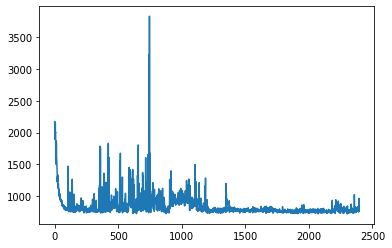

In [21]:
import matplotlib.pyplot as plt
plt.plot(rewards_storage)
plt.show

In [22]:
import pandas as pd

In [25]:
autoencoder.save_weights('saved_autoencoder_weights_1')
dqn_solver.model.save_weights('saved_dqn_weights_1')
df=pd.DataFrame(rewards_storage)
df.to_csv('rewards_1.csv')

In [26]:
for val in rewards_storage:
    if val>3000:
        print(val)

3221.0
3825.0
